VALORACIÓN DEL MODELO:

AUC (Area Under Curve): Discriminación del modelo (0.5 = aleatorio, 1 = perfecto)

KS (Kolmogorov-Smirnov): Màxima diferenica entre tasa de positivos y negativos acumulados.

ROC Curve: tasa verdaderos positivos vs falsos positivos

Accuracy: % tasa de aciertos (no és útil si no tienes 50/50 )

In [4]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib




Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


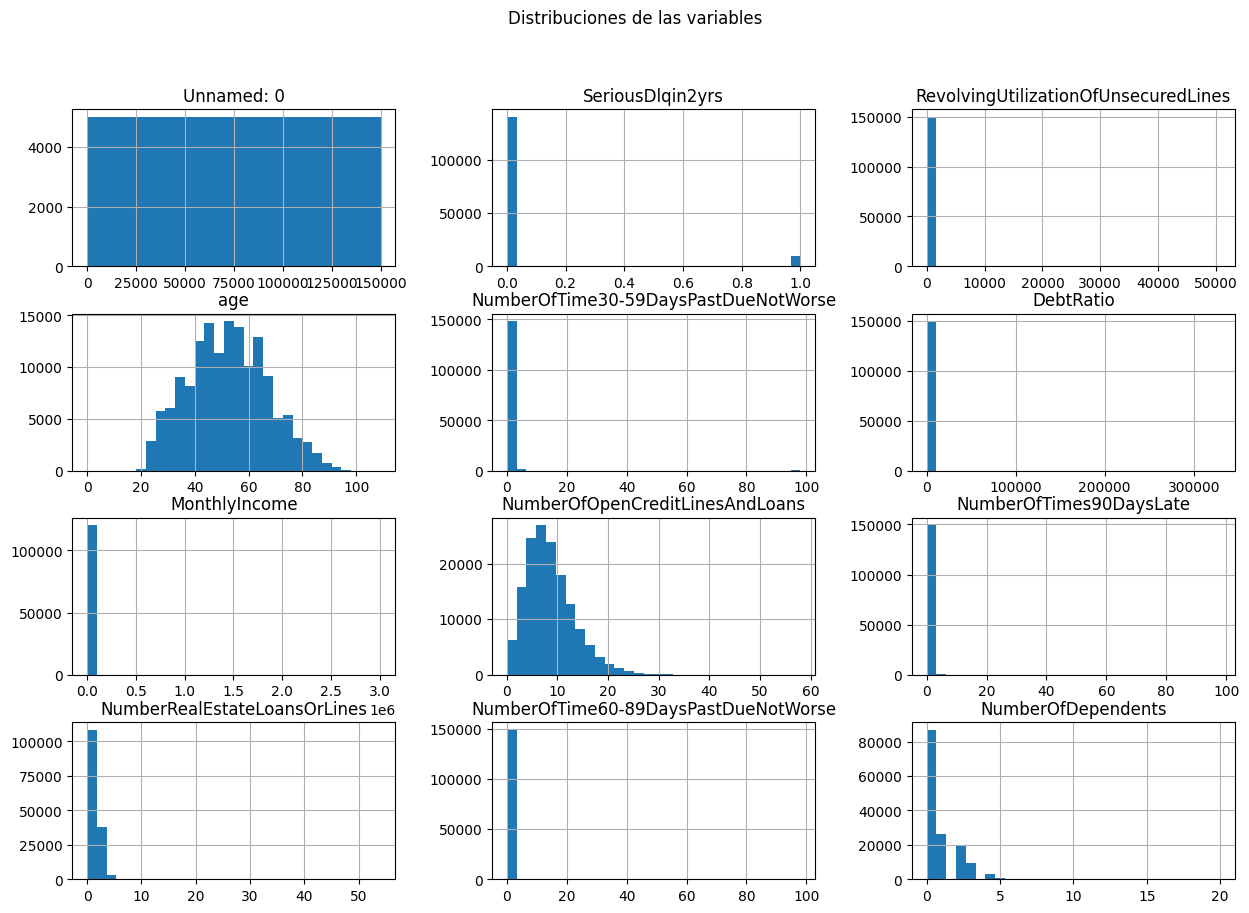

In [5]:
df = pd.read_csv(r'C:\Users\janbi\Desktop\Credit_Risk_Model\cs-training.csv\cs-training.csv')

print(df.columns)



df.hist(bins=30, figsize=(15,10))
plt.suptitle("Distribuciones de las variables")
plt.show()


| Variable                               | Qué significa                                   |
| -------------------------------------- | ----------------------------------------------- |
| `SeriousDlqin2yrs`                     |  Target: 1 = impago en 2 años, 0 = no impago  |
| `RevolvingUtilizationOfUnsecuredLines` | Uso de tarjetas respecto al límite              |
| `age`                                  | Edad del cliente                                |
| `NumberOfTime30-59DaysPastDueNotWorse` | Número de veces que se retrasó 30-59 días       |
| `DebtRatio`                            | Ratio deuda / ingreso                           |
| `MonthlyIncome`                        | Ingresos mensuales                              |
| `NumberOfOpenCreditLinesAndLoans`      | Número de cuentas abiertas (tarjetas, créditos) |
| `NumberOfTimes90DaysLate`              | Número de veces que se retrasó más de 90 días   |
| `NumberRealEstateLoansOrLines`         | Hipotecas u otros préstamos inmobiliarios       |
| `NumberOfTime60-89DaysPastDueNotWorse` | Retrasos de 60-89 días                          |
| `NumberOfDependents`                   | Número de personas a su cargo                   |


In [16]:
df = pd.read_csv(r'C:\Users\janbi\Desktop\Credit_Risk_Model\cs-training.csv\cs-training.csv').dropna()

X = df.drop(columns=["SeriousDlqin2yrs"])
Y = df["SeriousDlqin2yrs"]

#Division de los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [7]:
logistic_model = LogisticRegression(
    penalty='l2',#Tipo de regularización (una forma de evitar que el modelo aprenda "de más").
    dual=False,#True Solo si usas penalty='l2' y tienes más muestras (filas) que características (columnas)C=1.0(valor por defecto): Regularización moderada.C=100casi sin regularización.C=0.01regularización fuerte.
    solver='liblinear',#Algoritmo de optimización. 'liblinear' es bueno para datasets pequeños.
    class_weight='balanced',#Pondera las clases para evitar sesgos. si tienes mas clases que otra 
    max_iter=500,#Número máximo de iteraciones.
    verbose=1,#Muestra más información durante el entrenamiento.
)

parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

grid = GridSearchCV(
    estimator=logistic_model,
    param_grid=parameters,
    scoring='roc_auc',            # usamos AUC porque tienes clases desbalanceadas
    cv=5,                         # 5-fold cross-validation
    verbose=1,
    n_jobs=-1                     # usa todos los núcleos de CPU
)

grid.fit(X_train, Y_train)



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LibLinear]

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          solver='liblinear', verbose=1),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc', verbose=1)

In [8]:
print("Mejor valor de C encontrado:", grid.best_params_)
print("Mejor ROC AUC promedio en CV:", grid.best_score_)


best_model = grid.best_estimator_

Y_pred = best_model.predict(X_test)
Y_proba = best_model.predict_proba(X_test)[:, 1]

print("\Resultados en el conjunto de test:")
print(classification_report(Y_test, Y_pred))
print("ROC AUC en test:", roc_auc_score(Y_test, Y_proba))


Mejor valor de C encontrado: {'C': 100}
Mejor ROC AUC promedio en CV: 0.7927678503968516
\Resultados en el conjunto de test:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     33563
           1       0.22      0.61      0.32      2518

    accuracy                           0.82     36081
   macro avg       0.59      0.72      0.61     36081
weighted avg       0.91      0.82      0.86     36081

ROC AUC en test: 0.7969354136496757


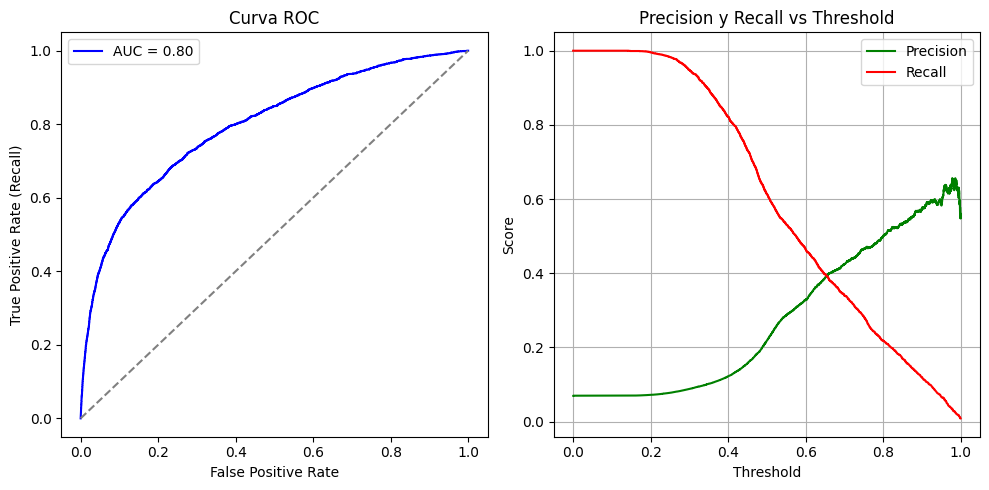

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report


precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_proba)


fpr, tpr, roc_thresholds = roc_curve(Y_test, Y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(thresholds, precisions[:-1], label='Precision', color='green')
plt.plot(thresholds, recalls[:-1], label='Recall', color='red')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision y Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_proba)


f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)  # +1e-6 evita división por cero

# Encuentra el threshold con mejor F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Mejor threshold por F1-score: {best_threshold:.2f}")
print(f"F1-score en ese threshold: {f1_scores[best_idx]:.2f}")

# Ahora aplicamos ese threshold
Y_pred_opt = (Y_proba >= best_threshold).astype(int)



print("Reporte con threshold optimizado:")
print(classification_report(Y_test, Y_pred_opt))

print("Matriz de confusión:")
print(confusion_matrix(Y_test, Y_pred_opt))


Mejor threshold por F1-score: 0.63
F1-score en ese threshold: 0.40
Reporte con threshold optimizado:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     33563
           1       0.36      0.43      0.40      2518

    accuracy                           0.91     36081
   macro avg       0.66      0.69      0.67     36081
weighted avg       0.92      0.91      0.91     36081

Matriz de confusión:
[[31641  1922]
 [ 1425  1093]]




PD (Probability Default): Probabilidad de que un cliente no pague.

LGD (Loss Given Default): % de pérdida en caso de impago.

EAD (Exposure at Default): Monto Expuesto en el momento de impago

EL (Expected Loss): EL = PD * LGD * EAD

In [11]:
model = grid.best_estimator_


joblib.dump(model, 'modelo_credito.pkl')

['modelo_credito.pkl']

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty='l2',
        class_weight='balanced',
        solver='liblinear',
        max_iter=500
    ))
])

pipeline.fit(X_train, Y_train)

# Guardar el pipeline completo
joblib.dump(pipeline, "modelo_credito.pkl")


['modelo_credito.pkl']